In [1]:
import sys
sys.path.append('../')
import LoadIntoDf

df = LoadIntoDf.load_sqlite_data()
# Display the DataFrame
df.head()


,p1447,p1073,p1448,p1074,p1449,p1075,p1450,p1076,p1451,p1077,...,p4838,p4839,p4840,p4841,p4842,p4843,p4844,p4845,angle,difficulty
uuid,,,,,,,,,,,,,,,,,,,,,
00007DA715CE4E7DBF60928D240CE7F2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,6b/V4
00007DA715CE4E7DBF60928D240CE7F2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,50,6a/V3
0004ff002424476b8e64256dbe0aed1f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,6a/V3
00079a6f946b4c26ba25123f77f41ea8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,4c/V0
00079a6f946b4c26ba25123f77f41ea8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60,7b/V8


In [2]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder


X = csr_matrix(df.drop('difficulty', axis=1).values)
y = df.difficulty.str.split('/').str[0]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [3]:
from xgboost import XGBClassifier
clf = XGBClassifier(device='cuda')
#bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
#clf.fit(X_train, y_train)

In [21]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:

# make predictions
y_pred = clf.predict(X_test)
y_pred_back = label_encoder.inverse_transform(y_pred)
y_test_back = label_encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)

0.19677224475705532

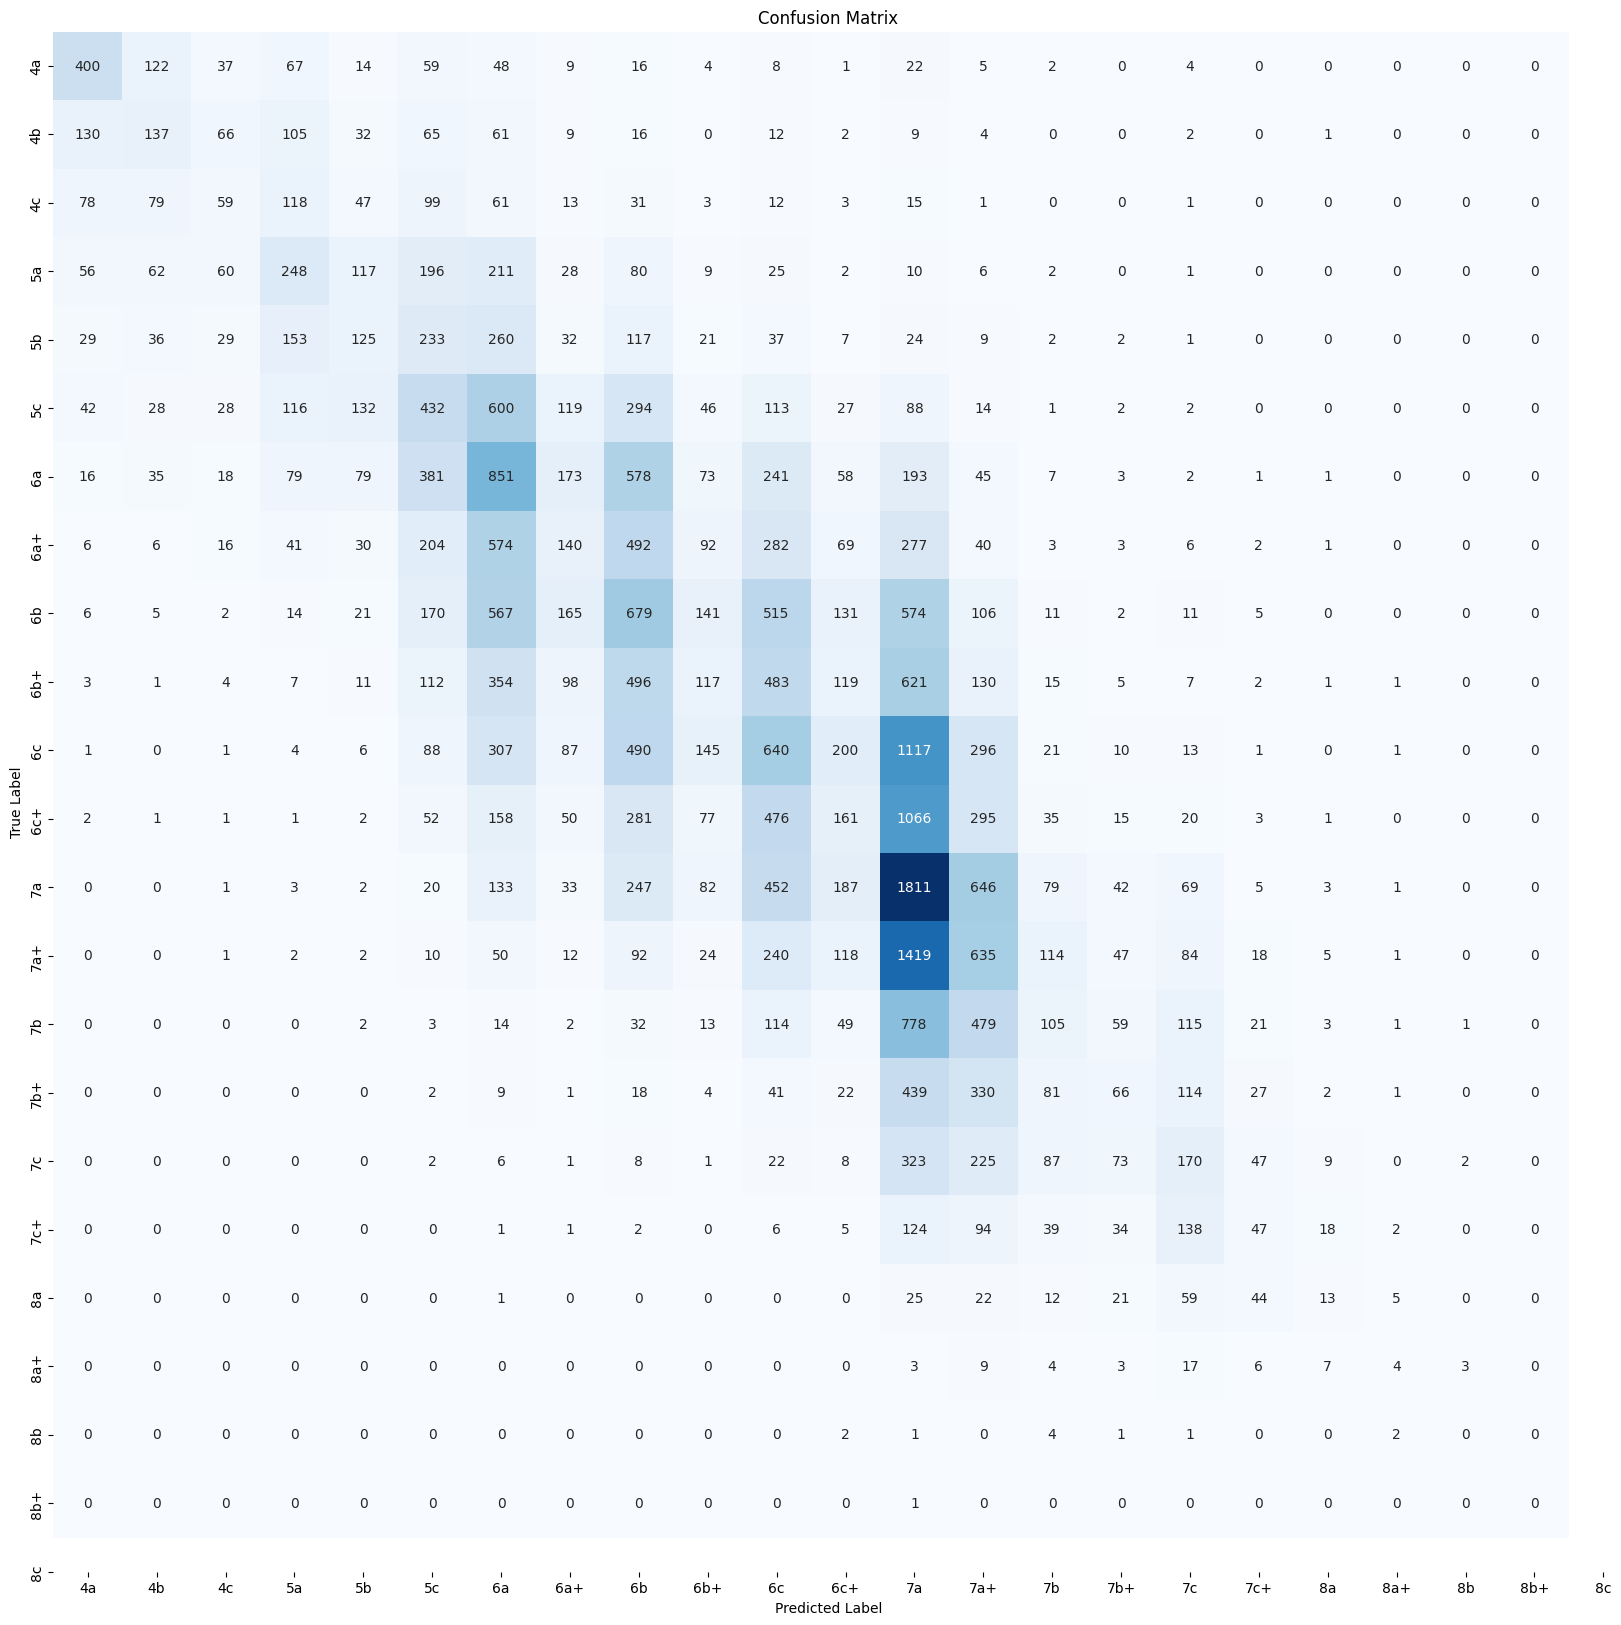

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)


# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')
plt.show()


In [7]:
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

clf = XGBClassifier(device='cuda')

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Highest accuracy found: ", grid_search.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/xgboost/core.py:160: UserWarning: [23:00:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/xgboost/core.py:160: UserWarning: [2

Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}
Highest accuracy found:  0.19890678941311854


Best parameters found:  `{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}`

Highest accuracy found:  `0.19890678941311854`

In [7]:
# Train final model with best parameters
best_xgb_model = clf.set_params(**{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9})
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_train)

/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/xgboost/core.py:160: UserWarning: [18:16:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [8]:
# make predictions
y_pred = clf.predict(X_test)
y_pred_back = label_encoder.inverse_transform(y_pred)
y_test_back = label_encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)

0.20206553321250828

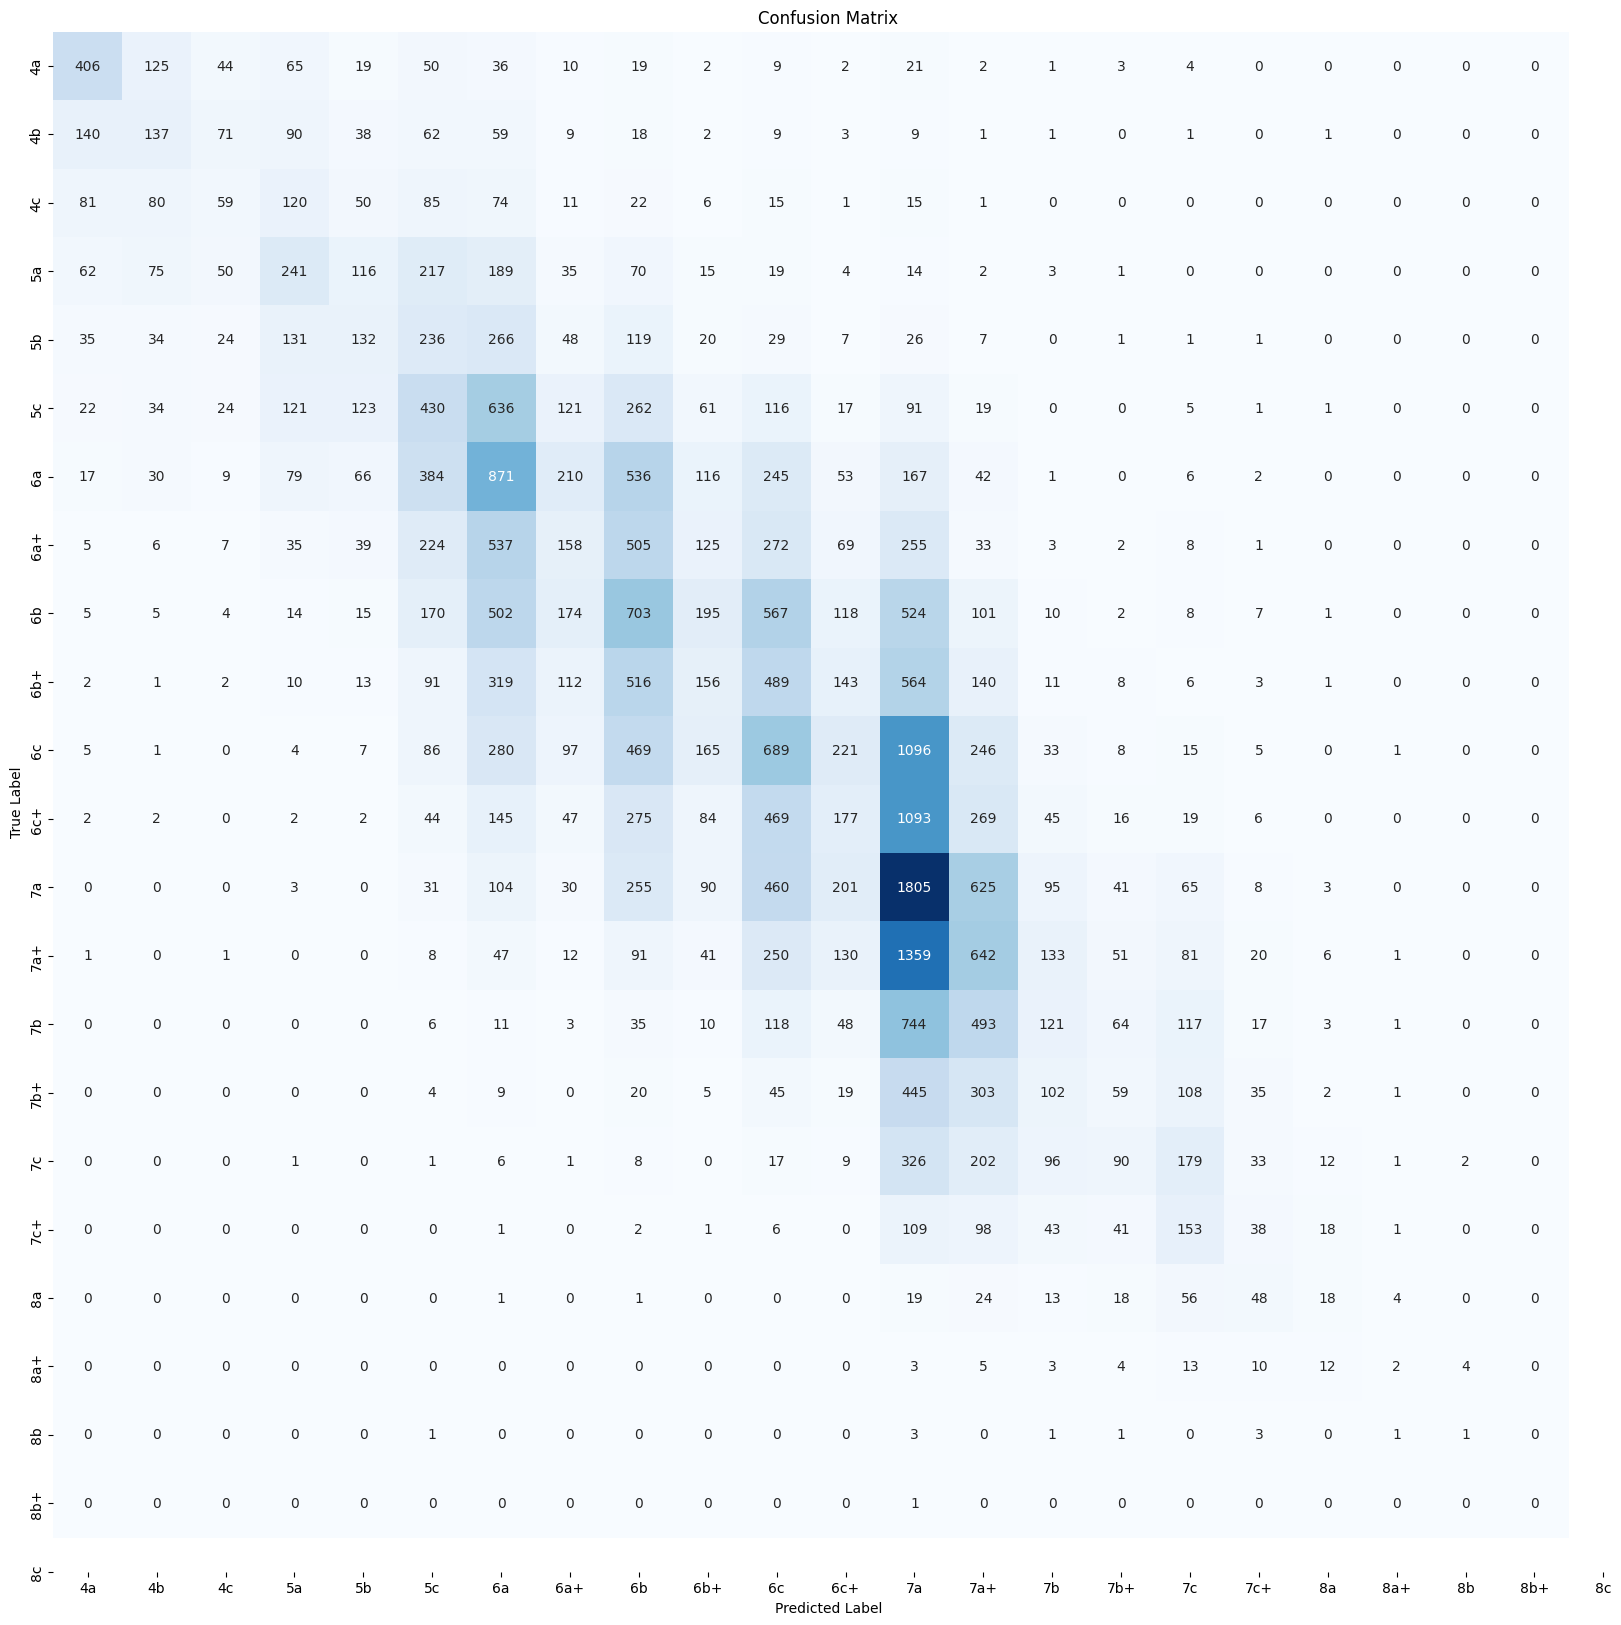

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)


# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_best_param.pdf', bbox_inches='tight')
plt.show()


In [17]:
label_encoder.classes_

array(['4a', '4b', '4c', '5a', '5b', '5c', '6a', '6a+', '6b', '6b+', '6c',
       '6c+', '7a', '7a+', '7b', '7b+', '7c', '7c+', '8a', '8a+', '8b',
       '8b+', '8c'], dtype=object)

In [4]:


best_xgb_model = clf.set_params(**{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9, 'objective': 'reg:squaredlogerror'})
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_train)

/home/isitar/Projects/cas-data-science/00_Projektarbeit/cas-project/lib64/python3.12/site-packages/xgboost/core.py:160: UserWarning: [21:45:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [5]:
# make predictions
y_pred = best_xgb_model.predict(X_test)
y_pred_back = label_encoder.inverse_transform(y_pred)
y_test_back = label_encoder.inverse_transform(y_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test_back, y_pred_back)

0.20206553321250828

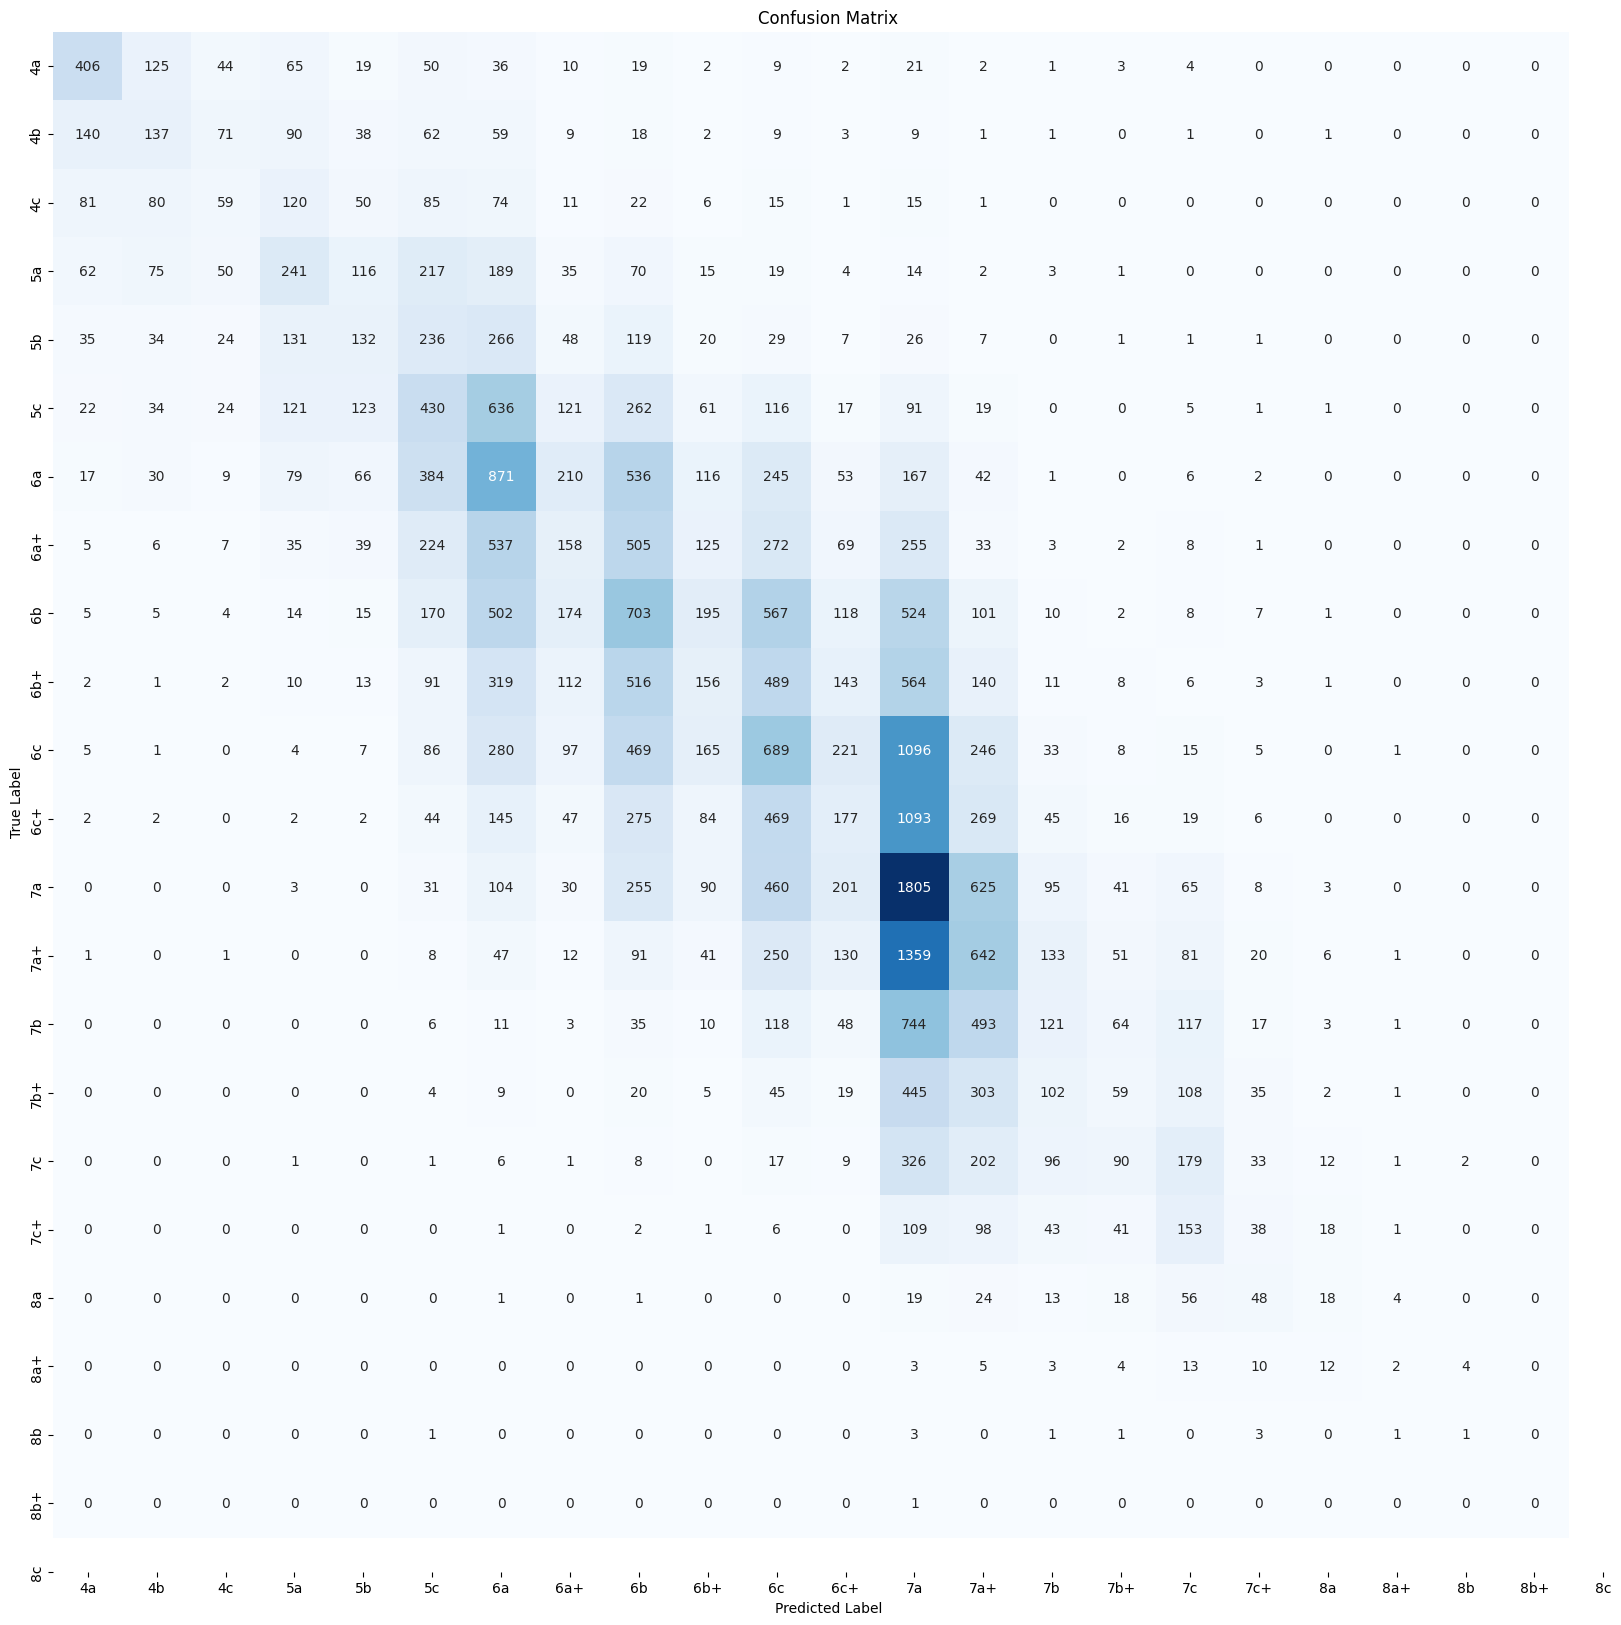

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_back, y_pred_back)


# Plot confusion matrix
plt.figure(figsize=(20, 20))  # Adjust the size here

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_best_param.pdf', bbox_inches='tight')
plt.show()
